In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# reading a csv file

df_main = pd.read_csv('/kaggle/input/ip-network-traffic-flows-labeled-with-87-apps/Dataset-Unicauca-Version2-87Atts.csv')

In [3]:
single_unique_cols = [col for col in df_main.columns if df_main[col].nunique() == 1]
df_main.drop(single_unique_cols, axis = 1, inplace = True)

df_main.drop(['Timestamp', 'Flow.ID'], axis = 1, inplace = True)

In [4]:
df_main.columns

Index(['Source.IP', 'Source.Port', 'Destination.IP', 'Destination.Port',
       'Protocol', 'Flow.Duration', 'Total.Fwd.Packets',
       'Total.Backward.Packets', 'Total.Length.of.Fwd.Packets',
       'Total.Length.of.Bwd.Packets', 'Fwd.Packet.Length.Max',
       'Fwd.Packet.Length.Min', 'Fwd.Packet.Length.Mean',
       'Fwd.Packet.Length.Std', 'Bwd.Packet.Length.Max',
       'Bwd.Packet.Length.Min', 'Bwd.Packet.Length.Mean',
       'Bwd.Packet.Length.Std', 'Flow.Bytes.s', 'Flow.Packets.s',
       'Flow.IAT.Mean', 'Flow.IAT.Std', 'Flow.IAT.Max', 'Flow.IAT.Min',
       'Fwd.IAT.Total', 'Fwd.IAT.Mean', 'Fwd.IAT.Std', 'Fwd.IAT.Max',
       'Fwd.IAT.Min', 'Bwd.IAT.Total', 'Bwd.IAT.Mean', 'Bwd.IAT.Std',
       'Bwd.IAT.Max', 'Bwd.IAT.Min', 'Fwd.PSH.Flags', 'Fwd.Header.Length',
       'Bwd.Header.Length', 'Fwd.Packets.s', 'Bwd.Packets.s',
       'Min.Packet.Length', 'Max.Packet.Length', 'Packet.Length.Mean',
       'Packet.Length.Std', 'Packet.Length.Variance', 'FIN.Flag.Count',
       'SYN.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

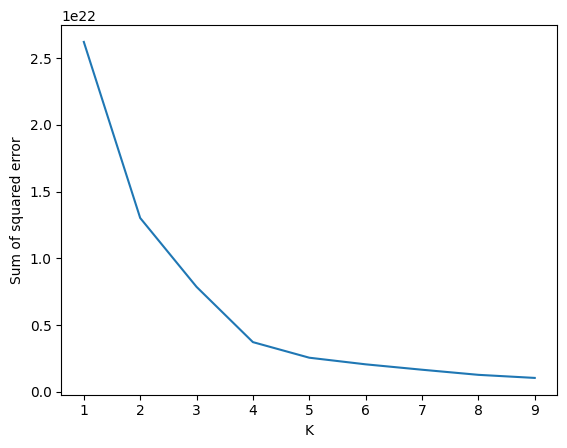

In [5]:
sse = []
k_rng = range(1,10)

for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df_main[['Flow.Duration', 'Total.Fwd.Packets', 'Total.Backward.Packets',
       'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets',
       'Fwd.Packet.Length.Mean', 'Bwd.Packet.Length.Mean', 'Flow.Bytes.s',
       'Flow.Packets.s', 'Down.Up.Ratio', 'Active.Mean']])
    sse.append(km.inertia_)
    
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

In [6]:
km = KMeans(n_clusters=4)

df_main['Label'] = km.fit_predict(df_main[['Flow.Duration', 'Total.Fwd.Packets', 'Total.Backward.Packets',
       'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets',
       'Fwd.Packet.Length.Mean', 'Bwd.Packet.Length.Mean', 'Flow.Bytes.s',
       'Flow.Packets.s', 'Down.Up.Ratio', 'Active.Mean']])

df_main['Label'].head()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    0
1    0
2    1
3    0
4    0
Name: Label, dtype: int32

In [7]:
df_main['Label'].value_counts()

Label
0    2710248
2     859546
1       6666
3        836
Name: count, dtype: int64

In [8]:
df_main0 = df_main[df_main.Label == 0]
df_main1 = df_main[df_main.Label == 1]
df_main2 = df_main[df_main.Label == 2]
df_main3 = df_main[df_main.Label == 3]

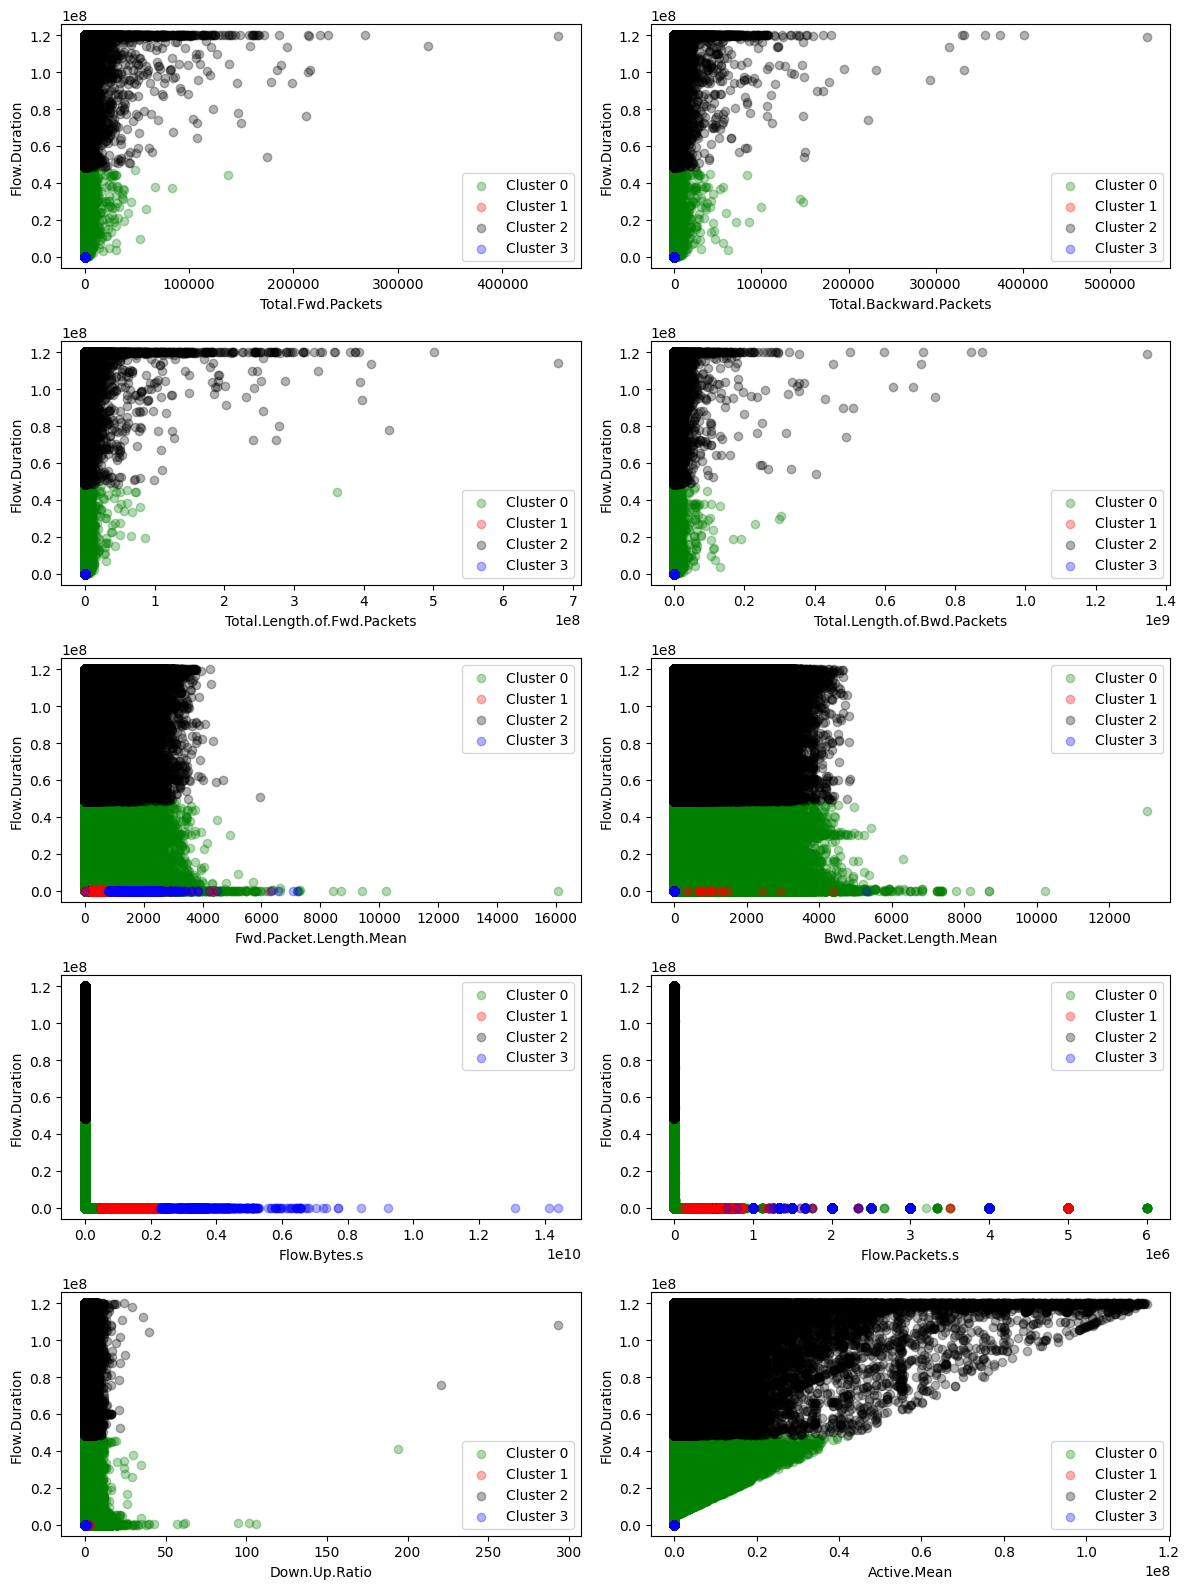

In [9]:
plot_columns = ['Total.Fwd.Packets', 'Total.Backward.Packets', 'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets', 'Fwd.Packet.Length.Mean', 'Bwd.Packet.Length.Mean', 'Flow.Bytes.s', 'Flow.Packets.s', 'Down.Up.Ratio', 'Active.Mean']

# Define the number of rows and columns for subplots
num_rows = 5
num_cols = 2

# Create a single big plot with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 16))

# Iterate through the columns and create subplots
for i, column in enumerate(plot_columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    ax.scatter(df_main0[column], df_main0['Flow.Duration'], color='green', label='Cluster 0', alpha=0.3)
    ax.scatter(df_main1[column], df_main1['Flow.Duration'], color='red', label='Cluster 1', alpha=0.3)
    ax.scatter(df_main2[column], df_main2['Flow.Duration'], color='black', label='Cluster 2', alpha=0.3)
    ax.scatter(df_main3[column], df_main3['Flow.Duration'], color='blue', label='Cluster 3', alpha=0.3)
    
    ax.set_xlabel(column)
    ax.set_ylabel('Flow.Duration')
    ax.legend()

# Adjust the layout and spacing
plt.tight_layout()
plt.show()


In [10]:
df_main = df_main[['Total.Fwd.Packets', 'Total.Backward.Packets', 'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets', 'Fwd.Packet.Length.Mean', 'Bwd.Packet.Length.Mean', 'Flow.Bytes.s', 'Flow.Packets.s', 'Down.Up.Ratio', 'Active.Mean', 'Label']]
df_main.columns

Index(['Total.Fwd.Packets', 'Total.Backward.Packets',
       'Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets',
       'Fwd.Packet.Length.Mean', 'Bwd.Packet.Length.Mean', 'Flow.Bytes.s',
       'Flow.Packets.s', 'Down.Up.Ratio', 'Active.Mean', 'Label'],
      dtype='object')

In [11]:
x = df_main.drop(columns = ['Label'])
y = df_main['Label']

scaler = StandardScaler()
x = scaler.fit_transform(x)

ncategories = len(y.unique())
print(ncategories)

4


In [12]:
y.shape

(3577296,)

In [13]:
# Split the data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

class_labels = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
print(class_weights)

del x_temp
del y_temp

# Define early stopping with custom monitor
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=0.001,  # Adjust as needed
    mode='min',  # Ensure the custom monitor minimizes recall loss
)

# Define a MirroredStrategy to use both GPUs
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

with strategy.scope():
    # Build the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(x.shape[1],)),  # Input layer with the appropriate input shape
        tf.keras.layers.Dense(64, activation='relu'),   # Fully connected layer with 64 units and ReLU activation
        tf.keras.layers.BatchNormalization(),  # Batch normalization layer
        tf.keras.layers.Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
        tf.keras.layers.BatchNormalization(),  # Batch normalization layer
        tf.keras.layers.Dense(256, activation='relu'),  # Fully connected layer with 256 units and ReLU activation
        tf.keras.layers.BatchNormalization(),  # Batch normalization layer
        tf.keras.layers.Dense(64, activation='relu'),   # Fully connected layer with 64 units and ReLU activation
        tf.keras.layers.BatchNormalization(),  # Batch normalization layer
        tf.keras.layers.Dense(4, activation='softmax')  # Output layer with 4 units and softmax activation for multi-class classification
    ])

     # Compile the model with categorical cross-entropy loss
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy', 'categorical_accuracy'])

# Train the model with early stopping
history = model.fit(
    x_train, tf.keras.utils.to_categorical(y_train, num_classes=4),
    epochs=1000,
    batch_size=128,
    validation_data=(x_val, tf.keras.utils.to_categorical(y_val, num_classes=4)),
    callbacks=[early_stopping],
    class_weight=dict(enumerate(class_weights))  # Assign class weights for each class
)

[3.30029533e-01 1.34167756e+02 1.03993746e+00 1.08874217e+03]
Epoch 1/1000
19564/19564 [==============================] - 269s 13ms/step - loss: 0.3087 - accuracy: 0.8676 - categorical_accuracy: 0.8676 - val_loss: 0.4075 - val_accuracy: 0.8584 - val_categorical_accuracy: 0.8584
Epoch 2/1000
19564/19564 [==============================] - 256s 13ms/step - loss: 0.2160 - accuracy: 0.9003 - categorical_accuracy: 0.9003 - val_loss: 0.3067 - val_accuracy: 0.8927 - val_categorical_accuracy: 0.8927
Epoch 3/1000
19564/19564 [==============================] - 258s 13ms/step - loss: 0.1906 - accuracy: 0.9044 - categorical_accuracy: 0.9044 - val_loss: 0.4749 - val_accuracy: 0.7537 - val_categorical_accuracy: 0.7537
Epoch 4/1000
19564/19564 [==============================] - 236s 12ms/step - loss: 0.1873 - accuracy: 0.9047 - categorical_accuracy: 0.9047 - val_loss: 0.3318 - val_accuracy: 0.9095 - val_categorical_accuracy: 0.9095
Epoch 5/1000
19564/19564 [==============================] - 232s 12ms/

In [14]:
train_logits = model.predict(x_train)
train_probabilities = tf.nn.softmax(train_logits, axis=-1)

# Calculate training accuracy
train_accuracy = sum(tf.argmax(train_logits, axis=1).numpy() == y_train) / len(y_train)

# Print training accuracy
print(f'Training Accuracy: {train_accuracy:.4f}')

del train_logits
del train_probabilities
del train_accuracy

78254/78254 [==============================] - 277s 4ms/step
Training Accuracy: 0.9198


In [15]:
validation_logits = model.predict(x_val)
validation_probabilities = tf.nn.softmax(validation_logits, axis=-1)

# Calculate validation accuracy
validation_accuracy = sum(tf.argmax(validation_logits, axis=1).numpy() == y_val) / len(y_val)

# Print validation accuracy
print(f'Validation Accuracy: {validation_accuracy:.4f}')

del validation_logits
del validation_probabilities
del validation_accuracy

16769/16769 [==============================] - 61s 4ms/step
Validation Accuracy: 0.9197


In [16]:
# Evaluate the model on the test data and apply softmax for probabilities
test_logits = model.predict(x_test)
test_probabilities = tf.nn.softmax(test_logits, axis=-1)

# Calculate accuracy for the test dataset
test_accuracy = sum(tf.argmax(test_logits, axis=1).numpy() == y_test) / len(y_test)

# Print test accuracy
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate a classification report for the test dataset
test_report = classification_report(y_test, tf.argmax(test_logits, axis=1).numpy())

# Print the classification report
print("Classification Report for Test Data:")
print(test_report)

del test_logits
del test_probabilities
del test_accuracy
del test_report

16769/16769 [==============================] - 61s 4ms/step
Test Accuracy: 0.9198
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95    406890
           1       0.89      1.00      0.94      1017
           2       0.82      0.85      0.84    128554
           3       0.99      0.90      0.94       134

    accuracy                           0.92    536595
   macro avg       0.91      0.92      0.92    536595
weighted avg       0.92      0.92      0.92    536595

